A **univariate** Hawkes process can be defined by the conditional intensity function

$$
\begin{align}
\lambda(t) &= \mu + \sum_{t_i < t} \phi(t - t_i) \\
\phi(x) &= \alpha \beta \exp (-\beta x ),
\end{align}
$$

where $\mu(t)$ is the background rate of event happening, the kernel $\phi(t)$ measures influence from the history, $\beta$ is the decay rate, and $\alpha$ is the size of the self-excited jumps.

A **multivariate** Hawkes process can be defined by the conditional intensity function

$$
\begin{align}
\lambda_k(t) &= \mu_k + \sum_{l} \sum_{t_i < t, c_i \in l} \phi_{l,k} (t - t_i)) \\
\phi(x) &= A_{l,k} \beta \exp (-\beta x ),
\end{align}
$$

where $\mu(t)$ is the background rate of event happening, the kernel $\phi(t)$ measures influence from the history, $\beta$ is the decay rate, and $\alpha$ is the size of the self-excited jumps. ${(t_i, c_i)}$ are the observed data, where $t_i \in \mathbb{R}+$ are the timestamps, and $c_i \in \{0, 1, ..., K\}$ are identifiers for which process a given occurrence belongs to. Furthermore, $l, k  \in \{0, 1, ..., K\}$, and $A$ is infectivity matrix ($A_{l,k}$ is interpretable as the expected number of further type-$k$ events that will be caused by events of type $l$).

In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Loading data

In [4]:
d_one = pd.read_csv('event_times_ond_d_1314_ds0_one.csv')
d_all = pd.read_csv('event_times_ond_d_1314_ds0_all.csv')

print(d_one['unit'].nunique(), "total units")
d_one.head()

41 total units


,time,unit
0,224.0,E08
1,8.0,E04
2,349.0,E09
3,100.0,B07
4,169.0,P20


In [5]:
# Obtaining units with >= 30 events

df_one_aug, df_all_aug = d_one, d_all
df_one_aug['unit_num'], df_all_aug['unit_num'] = pd.Categorical(d_one.unit).codes, pd.Categorical(d_all.unit).codes
#sorted_df_one_aug = df_one_aug.sort_values(by=['unit_num'])
#sorted_df_all_aug = df_all_aug.sort_values(by=['unit_num'])
df_one_aug_freq = df_one_aug.join(df_one_aug['unit_num'].value_counts().rename('frequency'), on='unit_num')
df_all_aug_freq = df_all_aug.join(df_all_aug['unit_num'].value_counts().rename('frequency'), on='unit_num')

threshold = 30
df_one_aug_freq_selected = df_one_aug_freq[df_one_aug_freq['frequency'] >= threshold] 
df_all_aug_freq_selected = df_all_aug_freq[df_all_aug_freq['frequency'] >= threshold]

num_selected_units_one = df_one_aug_freq_selected['unit'].nunique()
num_selected_units_all = df_all_aug_freq_selected['unit'].nunique()
print('Number of units with lots of events (d_one):', num_selected_units_one)
print('Number of units with lots of events (d_all):', num_selected_units_all)

df_one_aug_freq_selected.head()

Number of units with lots of events (d_one): 14
Number of units with lots of events (d_all): 16


,time,unit,unit_num,frequency
3,100.0,B07,1,52
4,169.0,P20,32,84
5,457.0,W11,40,45
6,308.0,P20,32,84
7,282.0,P20,32,84


In [6]:
# Mapping of unit names to numerical labels
mapping_one = df_one_aug_freq_selected.groupby(['unit', 'unit_num']).size().reset_index(name='frequency')[['unit', 'unit_num']]
mapping_all = df_all_aug_freq_selected.groupby(['unit', 'unit_num']).size().reset_index(name='frequency')[['unit', 'unit_num']]

# Mapping of unit names to numerical labels, with event frequencies 

mapping_one_freq = df_one_aug_freq_selected.groupby(['unit', 'frequency']).size().reset_index(name='freq')[['unit', 'frequency']]
mapping_all_freq = df_all_aug_freq_selected.groupby(['unit', 'frequency']).size().reset_index(name='freq')[['unit', 'frequency']]
                                                                                                           
'''
print('Mapping (one)')
print(mapping_one)
print('Mapping (all)')
print(mapping_all)
'''

print('Mapping (one), with frequency')
print(mapping_one_freq)
print('Mapping (all), with frequency')
print(mapping_all_freq)

Mapping (one), with frequency
   unit  frequency
0   B07         52
1   B12         36
2   E16         49
3   E19         32
4   G09         34
5   G11         52
6   L09         48
7   L10         66
8   P20         84
9   P22         31
10  W08         50
11  W09         45
12  W10         42
13  W11         45
Mapping (all), with frequency
   unit  frequency
0   B06         30
1   B07         57
2   B12         36
3   E16         50
4   E19         33
5   EMD        228
6   G09         34
7   G11         52
8   L09         51
9   L10         66
10  P20         84
11  P22         32
12  W08         51
13  W09         45
14  W10         43
15  W11         45


In [7]:
print(df_one_aug_freq_selected.shape)
print(df_all_aug_freq_selected.shape)

(666, 4)
(937, 4)


### Univariate

In [8]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP

In [9]:
def run_univariate(df):
    grouped = list(df.groupby(['unit']))
    dict_unit_params, dict_timestamps = {}, {}
    mu_list, alpha_list, omega_list = [], [], []
    for i in range(len(grouped)):
        unit = grouped[i][0]
        timestamps = grouped[i][1]['time'].values
        uv = UVHP()
        uv.fit(np.sort(timestamps), method="em")
        mu, alpha, omega = uv.get_params()
        mu_list.append(mu)
        alpha_list.append(alpha)
        omega_list.append(omega)
        dict_unit_params[unit] = (mu, alpha, omega)
        dict_timestamps[unit] = timestamps
    return dict_timestamps, mu_list, alpha_list, omega_list, dict_unit_params

In [10]:
dict_times_one, mu_list_one, alpha_list_one, omega_list_one, dict_unit_params_one = run_univariate(df_one_aug_freq_selected)
dict_times_all, mu_list_all, alpha_list_all, omega_list_all, dict_unit_params_all = run_univariate(df_all_aug_freq_selected)

print("Learned parameters (one):", dict_unit_params_one)
print("Learned parameters (all):", dict_unit_params_all)

'''
print("Learned mu values (one):", mu_list_one)
print("Learned alpha values (one):", alpha_list_one)
print("Learned omega values (one):", omega_list_one)
print("Learned mu values (all):", mu_list_all)
print("Learned alpha values (all):", alpha_list_all)
print("Learned omega values (all):", omega_list_all)
'''

Learned parameters (one): {'B07': (0.0956491149421797, 0.021814197939838652, 0.02299054724873966), 'B12': (0.05934365719440852, 0.11546918172857555, 0.08875160429808027), 'E16': (0.06426993935201539, 0.31590614489976243, 0.08105963134872723), 'E19': (0.062109510892314576, 0.008612461747844717, 0.00862551530171648), 'G09': (0.06970021692301015, 0.0017657106728751792, 0.03682436348533642), 'G11': (0.07231688599650916, 0.2724961203602354, 0.15486166486829953), 'L09': (0.08782153805496139, 0.012875621845713765, 0.028348266887147477), 'L10': (0.12178604412662376, 0.0038369342010943293, 0.025061471097130795), 'P20': (0.15380959507018704, 0.014381663837028909, 0.020805771508587794), 'P22': (0.049951530846844706, 0.14605590536581992, 0.5729063024122315), 'W08': (0.08788247251712794, 0.07701672655175767, 0.47715337869283153), 'W09': (0.07522935779816521, 0.08962767053091897, 991757199522824.0), 'W10': (0.08220230517605705, 0.014113520005493433, 0.05361902464957295), 'W11': (0.08087166140030683,

'\nprint("Learned mu values (one):", mu_list_one)\nprint("Learned alpha values (one):", alpha_list_one)\nprint("Learned omega values (one):", omega_list_one)\nprint("Learned mu values (all):", mu_list_all)\nprint("Learned alpha values (all):", alpha_list_all)\nprint("Learned omega values (all):", omega_list_all)\n'

#### Univariate plots

In [86]:
# Generating univariate HP plot for given unit

def hawkes_plot(unit, dict_learned, mapping_freq, smp, kind):
    '''
    kind: str, 'one' or 'all'
    '''
    mu, alpha, omega = dict_learned[unit]
    uv = UVHP()
    uv.set_params(mu, alpha, omega)
    num_events = mapping_freq.loc[mapping_freq['unit'] == unit, 'frequency'].item()
    func = [mu + np.sum(alpha * omega * np.exp(-omega * (x - smp[smp < x]))) for x in np.arange(0, max(smp), .1)]
    
    # plot
    plt.figure(figsize=(15,2))
    plt.title("Univariate HP (events_d_one)") if kind == 'one' else plt.title("Univariate HP (events_d_all)")
    plt.ylabel("$\lambda(t)$")
    plt.xlabel("$t$")
    plt.ylim(min(func)*0.9, max(func)*1.02) 
    plt.plot(smp, np.ones_like(smp) * min(func)*0.94, 'k.')
    _ = plt.plot(np.arange(0, max(smp), .1), func, 'g-')
    #print(num_events)
    #print(smp)
    #print(max(smp))
    #print(func)

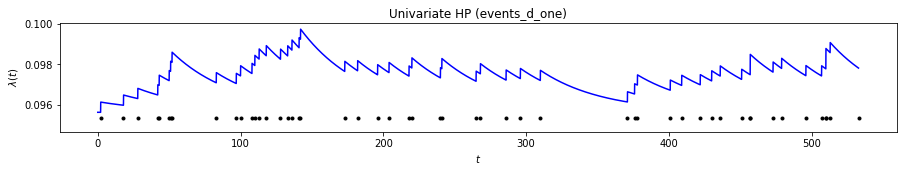

In [12]:
# events_d_one
unit = 'B07'
hawkes_plot(unit, dict_unit_params_one, mapping_one_freq, dict_times_one[unit], 'one')

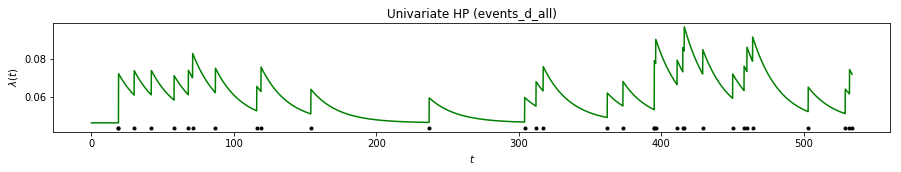

In [87]:
# events_d_all
unit = 'P22' #'EMD'
hawkes_plot(unit, dict_unit_params_all, mapping_all_freq, dict_times_all[unit], 'all')

### Multivariate

In [47]:
from hawkeslib import MultivariateExpHawkesProcess as MVHP

In [57]:
def run_multivariate(df):
    df_times_marks = df[['time', 'unit']].copy()
    df_times_marks['mark'] = pd.Categorical(df_times_marks.unit).codes
    df_times_marks = df_times_marks.sort_values(by=['time'])
    unit_label_freq_map = df[['unit', 'frequency']].copy() 
    unit_label_freq_map['label'] = pd.Categorical(unit_label_freq_map.unit).codes #df_times_marks['mark'].copy() 
    unit_label_freq_map = unit_label_freq_map.groupby(['unit', 'frequency', 'label']).size().reset_index(name='freq')[['unit', 'frequency', 'label']]
    
    mv = MVHP()
    timestamps = df_times_marks['time'].values
    marks = df_times_marks['mark'].values
    mv.fit(timestamps, marks, method="em") 
    mu_vect, Alpha_matrix, omega_val = mv.get_params()
    return mu_vect, Alpha_matrix, omega_val, unit_label_freq_map

In [58]:
mu_one, Alpha_one, omega_one, mv_map_one = run_multivariate(df_one_aug_freq_selected)
mu_all, Alpha_all, omega_all, mv_map_all = run_multivariate(df_all_aug_freq_selected)

#print('mu vector:', mu_one)
#print('Alpha matrix:', Alpha_one)
#print('omega value:', omega_one)

print('Key (one):\n', mv_map_one)
print('Key (all):\n', mv_map_all)

Key (one):
    unit  frequency  label
0   B07         52      0
1   B12         36      1
2   E16         49      2
3   E19         32      3
4   G09         34      4
5   G11         52      5
6   L09         48      6
7   L10         66      7
8   P20         84      8
9   P22         31      9
10  W08         50     10
11  W09         45     11
12  W10         42     12
13  W11         45     13
Key (all):
    unit  frequency  label
0   B06         30      0
1   B07         57      1
2   B12         36      2
3   E16         50      3
4   E19         33      4
5   EMD        228      5
6   G09         34      6
7   G11         52      7
8   L09         51      8
9   L10         66      9
10  P20         84     10
11  P22         32     11
12  W08         51     12
13  W09         45     13
14  W10         43     14
15  W11         45     15


#### Multivariate plots

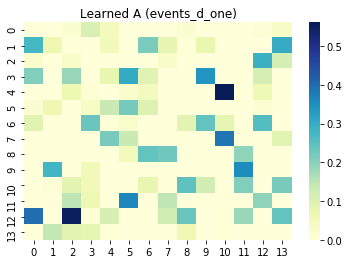

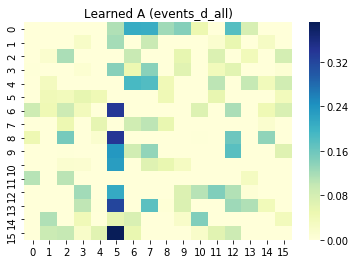

In [59]:
# Alpha depictions

ax0 = sns.heatmap(Alpha_one, cmap="YlGnBu")
ax0.set_title("Learned A (events_d_one)")
plt.show()

ax1 = sns.heatmap(Alpha_all, cmap="YlGnBu")
ax1.set_title("Learned A (events_d_all)")
plt.show()

Text(0.5, 1.0, '$\\mu_k$ (events_d_all)')

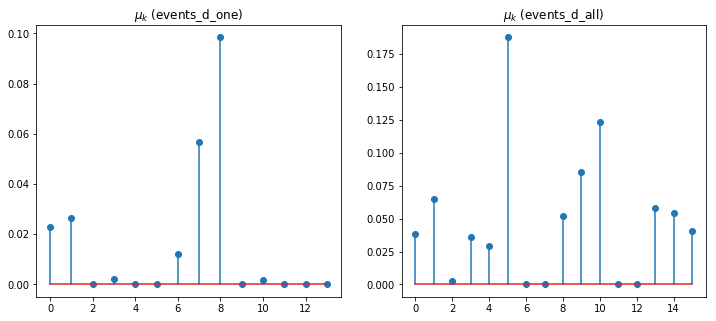

In [63]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].stem(mu_one)
ax[0].set_title("$\mu_k$ (events_d_one)")
ax[1].stem(mu_all)
ax[1].set_title("$\mu_k$ (events_d_all)")

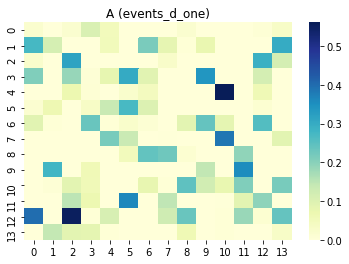

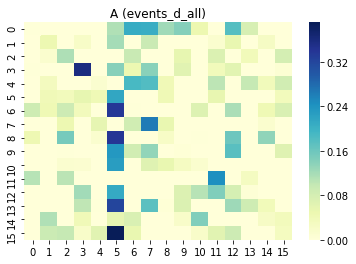

In [65]:
# Replacing diagonals of A_events_d_one and A_events_d_all with learned univariate alpha values

A_events_d_one_copy = Alpha_one
A_events_d_all_copy = Alpha_all
np.fill_diagonal(A_events_d_one_copy, alpha_list_one)
np.fill_diagonal(A_events_d_all_copy, alpha_list_all)

ax0 = sns.heatmap(A_events_d_one_copy, cmap="YlGnBu") # "Blues"
ax0.set_title("A (events_d_one)")
plt.show()

ax1 = sns.heatmap(A_events_d_all_copy, cmap="YlGnBu") # "Blues"
ax1.set_title("A (events_d_all)")
plt.show()